In [129]:
import math
import gmplot
import json
from matplotlib import pyplot as plt

In [130]:
with open("log_decoded_1.txt", 'r') as f:
    lines = f.readlines()
print(len(lines))
gyroDat : list[str] = []
latDat : list[str] = []
lonDat : list[str] = []
latCount = 0
lonCount = 0
for latIndex, line in enumerate(lines):
    if "Lat" in line:
        latCount += 1
    elif "Lon" in line:
        lonCount += 1
    trimmed = line.replace("LOG", "").strip()
    if trimmed.startswith("{\"acceleration\":"):
        gyroDat.append(trimmed)
    elif trimmed.startswith("Lat:"):
        latDat.append(trimmed)
    elif trimmed.startswith("Lon:"):
        lonDat.append(trimmed)
        
print(len(gyroDat))
print(len(latDat))
print(len(lonDat))

5546
1900
1819
1819


In [131]:
lonDatStripped = [float(i.replace("Lon:", "").strip()) for i in lonDat]
latDatStripped = [float(i.replace("Lat:", "").strip()) for i in latDat]

In [132]:
def distBetweenPoints(lat1, lon1, lat2, lon2):
    return(math.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2))

# Lat Lon plotting & furthest distance
gmap = gmplot.GoogleMapPlotter(latDatStripped[0], lonDatStripped[0], 13)
gmap.plot(latDatStripped, lonDatStripped, color="red", edge_width=2)

farthestDist = 0
deskCoords = (latDatStripped[0], lonDatStripped[0])
distancesFromDesk = []
for lonIndex, (lat, lon) in enumerate(zip(latDatStripped, lonDatStripped)):
    currentDist = distBetweenPoints(lat, lon, deskCoords[0], deskCoords[1])
    distancesFromDesk.append(currentDist)
    if currentDist > farthestDist:
        farthestDist = distBetweenPoints(lat, lon, deskCoords[0], deskCoords[1])
        print(f"New farthest distance = {farthestDist}")
        farthestCoords = (lat, lon)
        farthestIndex = lonIndex

gmap.marker(deskCoords[0], deskCoords[1])
gmap.marker(farthestCoords[0], farthestCoords[1])
print(f"Start: ({latDatStripped[0]}, {lonDatStripped[0]})")
print(f"Farthest: ({farthestCoords[0]}, {farthestCoords[1]}), Dist: {farthestDist}")
print(f"End: ({latDatStripped[-1]}, {lonDatStripped[-1]})")

gmap.draw("plot.html")

New farthest distance = 0.00011403602273326151
New farthest distance = 0.00012375384033687893
New farthest distance = 0.00016950398698812862
New farthest distance = 0.00020380430151882854
New farthest distance = 0.00021273483813832167
New farthest distance = 0.00021931977320041569
New farthest distance = 0.00022164930819936656
Start: (-36.75248284530575, 174.69704609332945)
Farthest: (-36.752669583108975, 174.6969266889381), Dist: 0.00022164930819936656
End: (-36.752588152919664, 174.69703481548902)


![A very innacurate position track](log1_map.png)
Pretty damn innacurate

Immediately after standing, position drifts by 0.0001, furthest position from start is distance of 0.00022. Try threshold of 0.00015.<br>
Could convert units to meters https://en.wikipedia.org/wiki/Haversine_formula

In [133]:
# Associate nearest timestamp with lat and lon values
with open("log_decoded_1.txt", 'r') as f:
    lines = f.readlines()
print(len(lines))
tstamps = []
lats = []
lons = []

# If a lat value found, find the nearest lon and timestamp values, then look for next lat value
for latIndex, line in enumerate(lines):
    if "Lat" in line:
        lat = line.replace("LOG", "").replace("Lat:", "").strip()
        for lonIndex in range(latIndex, len(lines)):
            if "Lon" in lines[lonIndex]:
                # print(f"Lon found {lonIndex-latIndex} indexes after lat")
                lon = lines[lonIndex].replace("LOG", "").replace("Lon:", "").strip()
                for tstampIndex in range(lonIndex, len(lines)):
                    if "acceleration" in lines[tstampIndex]:
                        # print(f"Tstamp found {tstampIndex-lonIndex} indexes after lon")
                        tstamp = json.loads(lines[tstampIndex].replace("LOG", "").strip())['acceleration']['timestamp']
                        tstamps.append(tstamp)
                        lats.append(lat)
                        lons.append(lon)
                        break
                break

print(f"tstamps: {len(tstamps)}, lats: {len(lats)}, lons: {len(lons)}")
# for i in range(0, 10):
#     print(f"tstamp: {tstamps[i]}, lat: {lats[i]}, lon: {lons[i]}")

5546
tstamps: 1819, lats: 1819, lons: 1819


In [134]:
import plotly
import plotly.express

# Distance from desk over time
fig = plotly.express.line(x=tstamps, y=distancesFromDesk)
fig.show()

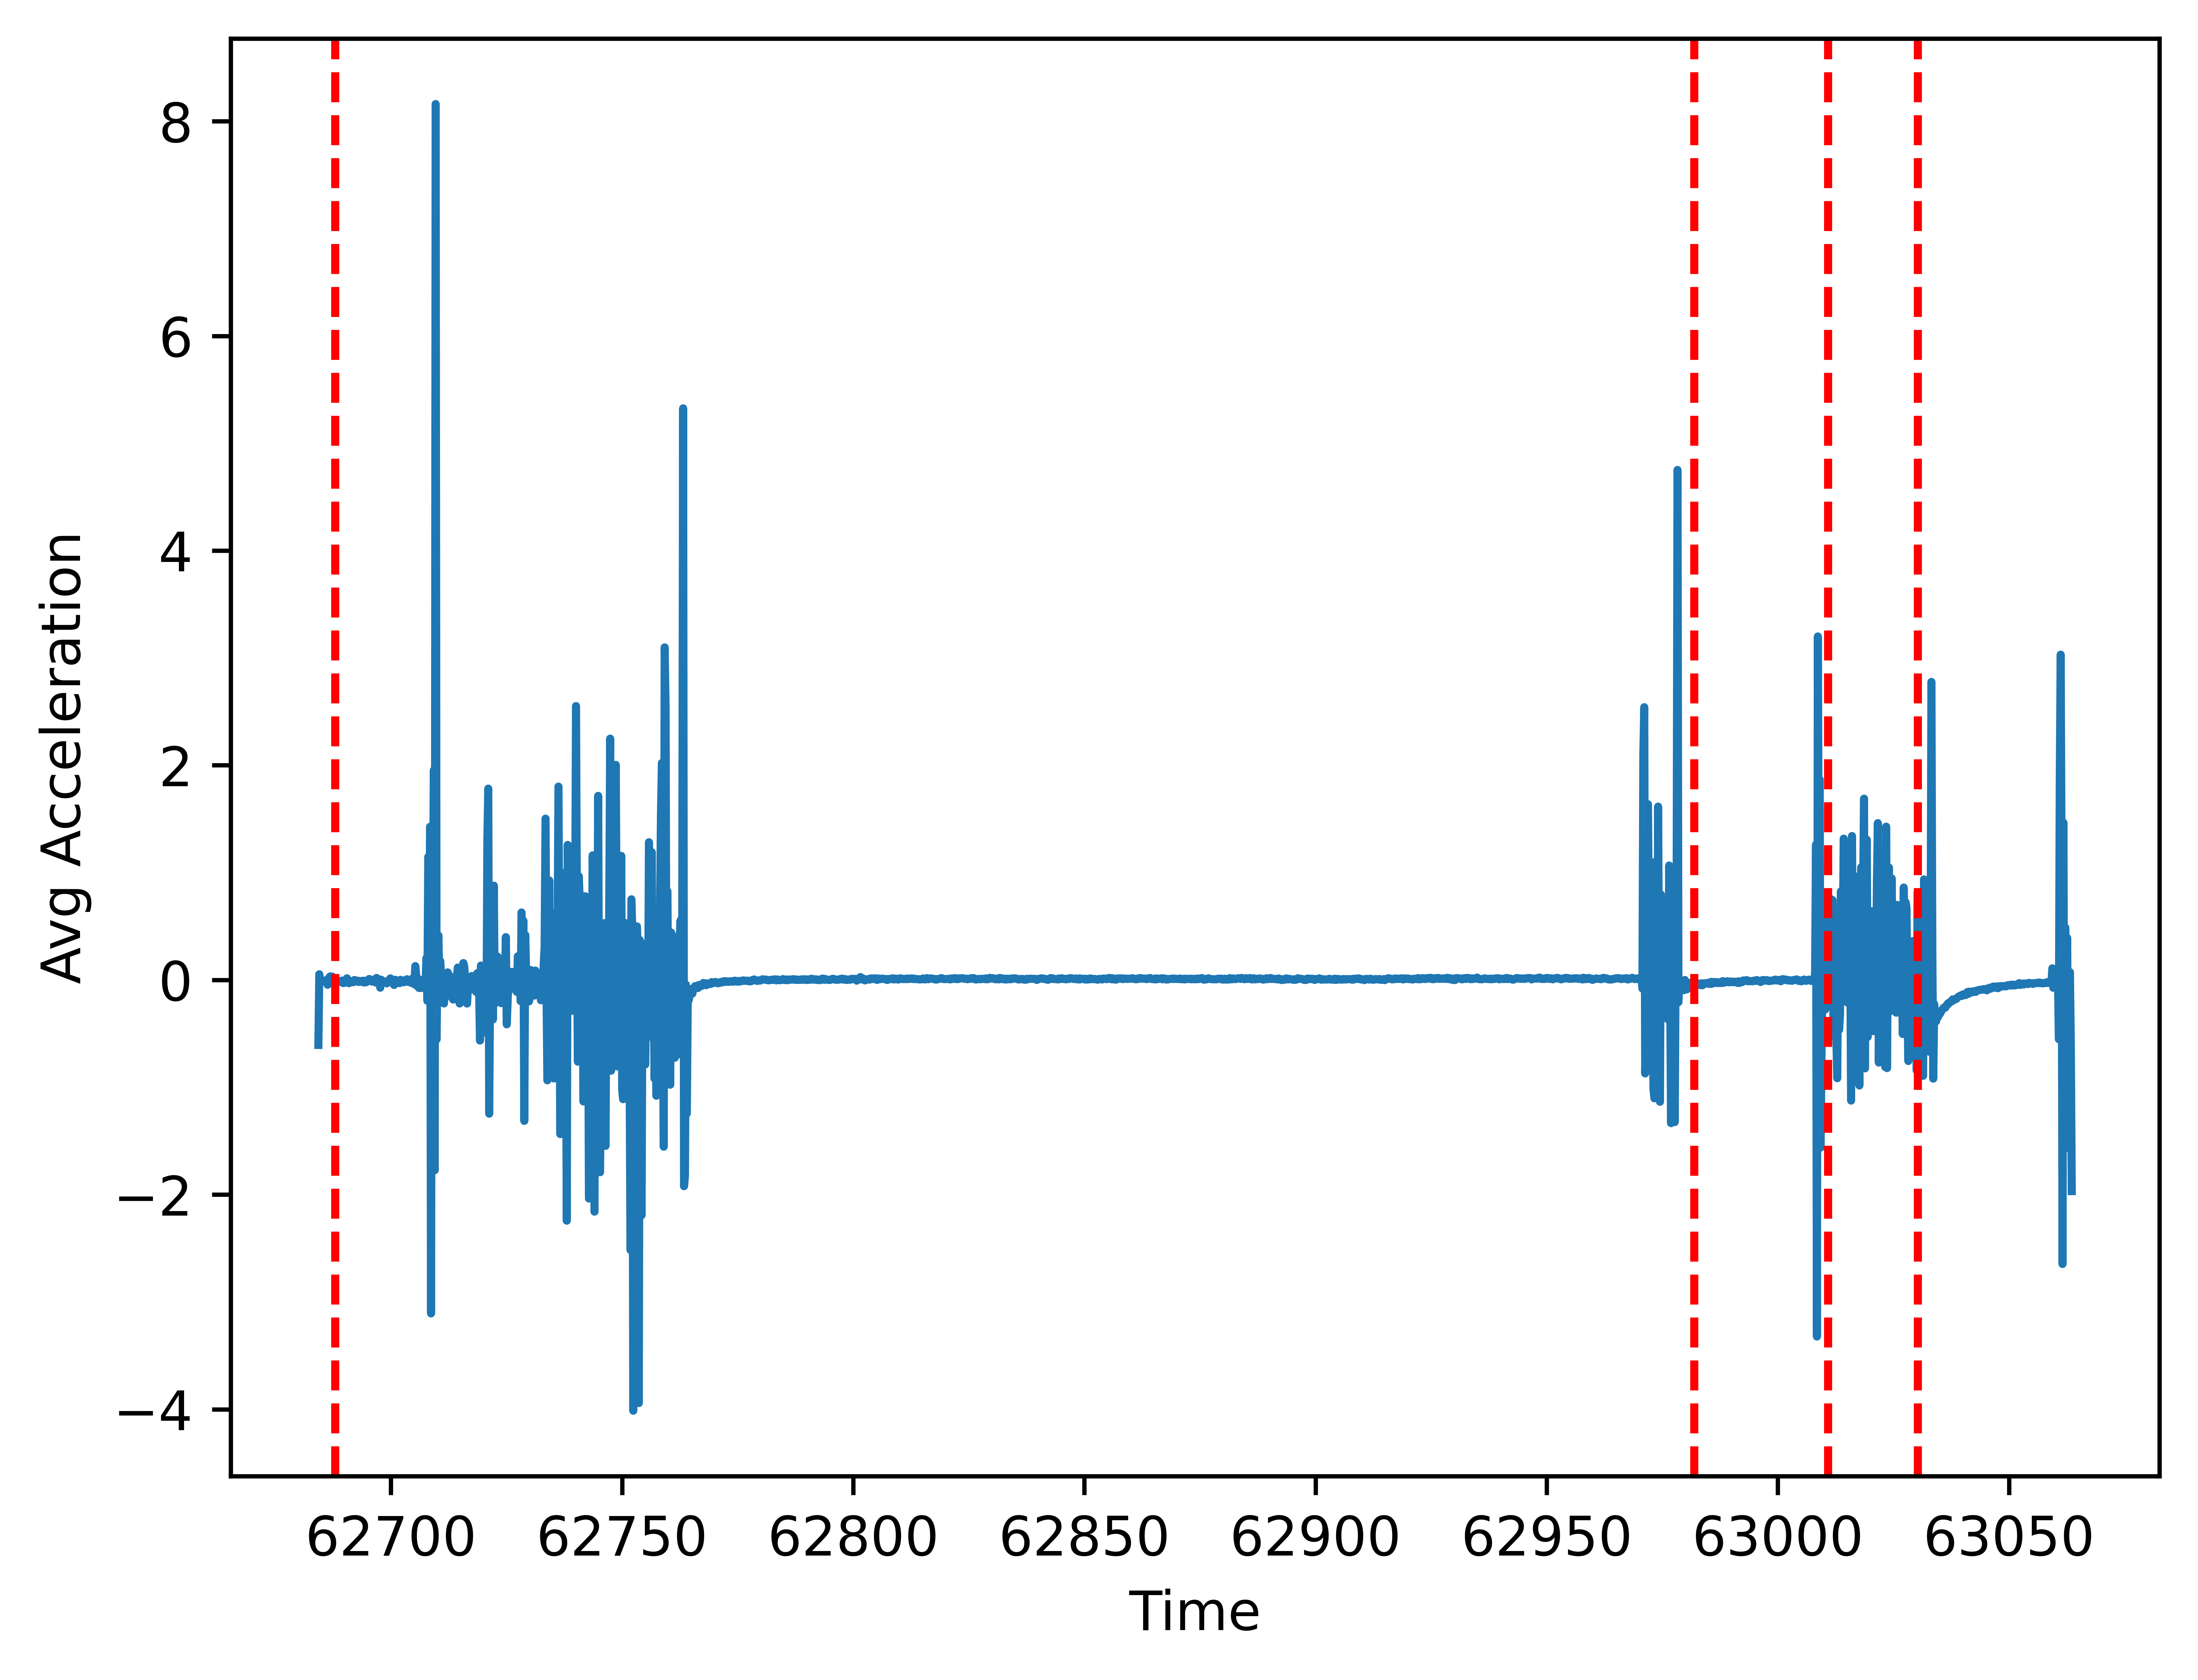

In [135]:
def avgAccel(reading : dict) :
    return (reading['acceleration']['x'] + reading['acceleration']['y'] + reading['acceleration']["z"]) / 3

avgAccelDat = [avgAccel(json.loads(reading)) for reading in gyroDat]
avgAccelTimestamp = [json.loads(reading)['acceleration']['timestamp'] for reading in gyroDat]
plt.figure(dpi=1200)
plt.xlabel("Time")
plt.ylabel("Avg Acceleration")
plt.plot(avgAccelTimestamp, avgAccelDat)

timestamps = [62687.895989875, 62981.885259375005, 63030.21808525, 63010.845179125005]
for t in timestamps:
    plt.axvline(x=t, color="red", linestyle="--")

plt.show()

In [136]:
import plotly
import plotly.express
import plotly.graph_objects

def absAvgAccel(reading : dict) :
    return (abs(reading['acceleration']['x']) + abs(reading['acceleration']['y']) + abs(reading['acceleration']["z"])) / 3

def movingAverage(data : list, window : int):
    movingAverage = []
    for i in range(window-1, len(data)):
        movingAverage.append(sum(data[i-window+1:i]) / window)
    return movingAverage

absAvgAccelDat = [absAvgAccel(json.loads(reading)) for reading in gyroDat]
absAvgAccelTimestamp = [json.loads(reading)['acceleration']['timestamp'] for reading in gyroDat]

# Do some smoothing
absMovingAvgAccel10 = movingAverage(absAvgAccelDat, 10)
absMovingAvgAccel50 = movingAverage(absAvgAccelDat, 50)

# plt.figure(dpi=1200)
# plt.xlabel("Time")
# plt.ylabel("Absolute Avg Acceleration")
# plt.plot(absAvgAccelTimestamp, absAvgAccelDat)

fig = plotly.express.line(x=absAvgAccelTimestamp, y=absAvgAccelDat)
fig.add_trace(plotly.graph_objects.Scatter(x=absAvgAccelTimestamp, y=absMovingAvgAccel10, name="Avg w=10"))
fig.add_trace(plotly.graph_objects.Scatter(x=absAvgAccelTimestamp, y=absMovingAvgAccel50, name="Avg w=50"))
fig.update_layout(height=700, width=1100, xaxis_title="Time", yaxis_title="Absolute Avg Acceleration")

timestamps = [62687.895989875, 62981.885259375005, 63030.21808525, 63010.845179125005]
for t in timestamps:
    # plt.axvline(x=t, color="red", linestyle="--")
    fig.add_vline(x=t, line_width=1, line_dash="dash", line_color="red")

# plt.show()
fig.show()

Sharp spike to > 3.5 seems like decent indicator for 'stood up'

Average accel for last 10s of greater than 0.5 could be ok for 'in motion', but probably better to do sensor fusion w/ position & estimate velocity (not now)

In [137]:
print(absAvgAccelDat)
print(absAvgAccelDat.index(8.160206101821611))

[0.8906366609025745, 0.09297082472561548, 0.025263632771683236, 0.020983191151047745, 0.015204388553897538, 0.017404869917780157, 0.015394266836500416, 0.017740836051416894, 0.005137496841388444, 0.012088223205972463, 0.04783062860422457, 0.026831764960009604, 0.025691575860170023, 0.05012300168018167, 0.021331627084997792, 0.030774584301654247, 0.014672400569046536, 0.024747213770914822, 0.042926459505905706, 0.017738887645117937, 0.02061505195839951, 0.023529100596656402, 0.020918181357129167, 0.022543091322761027, 0.017534493735587846, 0.020555266328870007, 0.015949038997509827, 0.033830117681063705, 0.026606608345856268, 0.024240695109652974, 0.00794392038670679, 0.016530772230681032, 0.018989484405641754, 0.03679022177321215, 0.013280812257714568, 0.016761335672313967, 0.01908319665985182, 0.05017634539138525, 0.03406609403894593, 0.007307315161141256, 0.021687698336131867, 0.012642782260042925, 0.022066419810491303, 0.01604855993799865, 0.02571028664940968, 0.013516776438057423, 

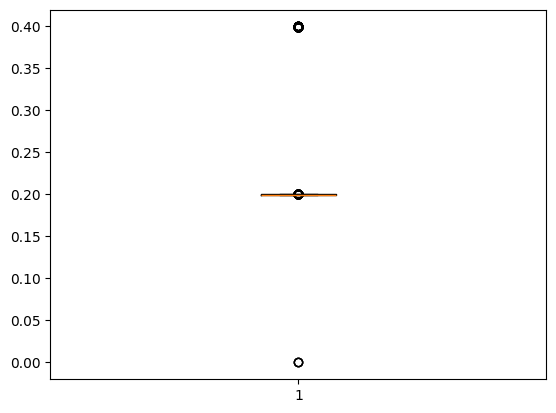

In [138]:
# Find dt

tstampDiff = []
for i in range(len(tstamps)):
    if i != 0:
        tstampDiff.append(tstamps[i] - tstamps[i-1])

plt.figure()
plt.boxplot(tstampDiff)
plt.show()

In [139]:
import numpy
import plotly
import plotly.subplots

fltLats = list(map(float, lats))
fltLons = list(map(float, lons))

fig = plotly.subplots.make_subplots(rows=1, cols=2)
# Computational derivative of lat/lon, instantaneous rate of change useful for movement estimation?
fig.add_trace(plotly.graph_objs.Scatter(x=tstamps, y=numpy.gradient(fltLats, 0.2).tolist(), name="Latitude"), row=1, col=1)
fig.add_trace(plotly.graph_objs.Scatter(x=tstamps, y=numpy.gradient(fltLons, 0.2).tolist(), name="Longitude"), row=1, col=2)
fig.update_layout(height=500, width=1000)

timestamps = [62687.895989875, 62981.885259375005, 63030.21808525, 63010.845179125005]
for t in timestamps:
    fig.add_vline(x=t, line_dash="dash", line_color="red")

fig.show()

### Summary
Implementation to try
- Sudden transition from ~0 avg accel to >3.5 = 'stood up'
- Mark current position as start point
- Watch for movement to new position at least 0.00015 units away
- Avg accel settles to ~0 (<0.5) again for at least 2 mins
- Trigger notification on detecting stood up again